In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from mmf_speckle import *
from __init__ import *

In [3]:
import torch
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
import numpy as np

In [4]:
device="cuda"
dtype=torch.float64
root="./results"

## Data Preparation

In [5]:
nosie_sigma=0
nosie=nosie_sigma>0
Width = 128
Height = 128
N = Width*Height
rate = 0.1526
M = int(N*rate)
print(M, N, N//M)

2500 16384 6


In [6]:
A_u = get_mmf_speckle_measure_matrix(25,device,dtype)

In [7]:
# reconstruction of 7 unknown images
names=[
    "GI",
    "Baboon",
    "Peppers",
    "Goldhill",
    "Barbara",
    "Cameraman",
    "Lena"
]
y_uu_list = [] 
x_uu_list = []
for name in names:
    x_u = get_gi_image(0,device, dtype) if name=="GI" else get_t_image(name,device, dtype,W=Width,H=Height)
    y_u = speckle_measure(A_u, x_u.reshape((-1,1)), nosie=nosie, nosie_sigma=nosie_sigma) 
    y_uu_list.append(y_u)
    x_uu_list.append(x_u)

## Mismatch Recv

In [10]:
A_recv = get_mmf_speckle_measure_matrix(0,device,dtype)

In [8]:
from trad_cs_recv_algos import *

In [9]:
W = dct_matrix(N,dtype=dtype,device=device)
WT = torch.inverse(W)

In [11]:
tau=.35
stopCri = 4
tolA = 1.e15
tolD = 0.0001

In [14]:
recv_res=[]
error_res=[]
for j in range(len(names)):
    y = y_uu_list[j]
    error = y - A_recv @ x_uu_list[j].reshape((-1,1))
    e = abs(error).mean()
    print(e)

    AW = A_recv @ W
    hR = lambda x: AW @ x
    AT = lambda x: AW.T @ x

    [theta,theta_debias,obj_GPSR_Basic,times_GPSR_Basic,debias_s,mses_GPSR_Basic] = \
        GPSR_Basic(
          y,hR,tau,device,dtype,
            Debias=0,
            AT=AT,
            Initialization=AT(y),
            StopCriterion=stopCri,
            ToleranceA=tolA,
            ToleranceD=tolD,
            Iters=100,
            Verbose=False
        )
    recv_img = (W @ theta)
    print("done")
    recv_res.append(recv_img)
    error_res.append(e.item())

tensor(82.7658, device='cuda:0', dtype=torch.float64)
done
tensor(249.3868, device='cuda:0', dtype=torch.float64)
done
tensor(208.1724, device='cuda:0', dtype=torch.float64)
done
tensor(232.1339, device='cuda:0', dtype=torch.float64)
done
tensor(219.6519, device='cuda:0', dtype=torch.float64)
done
tensor(247.2745, device='cuda:0', dtype=torch.float64)
done
tensor(247.2529, device='cuda:0', dtype=torch.float64)
done


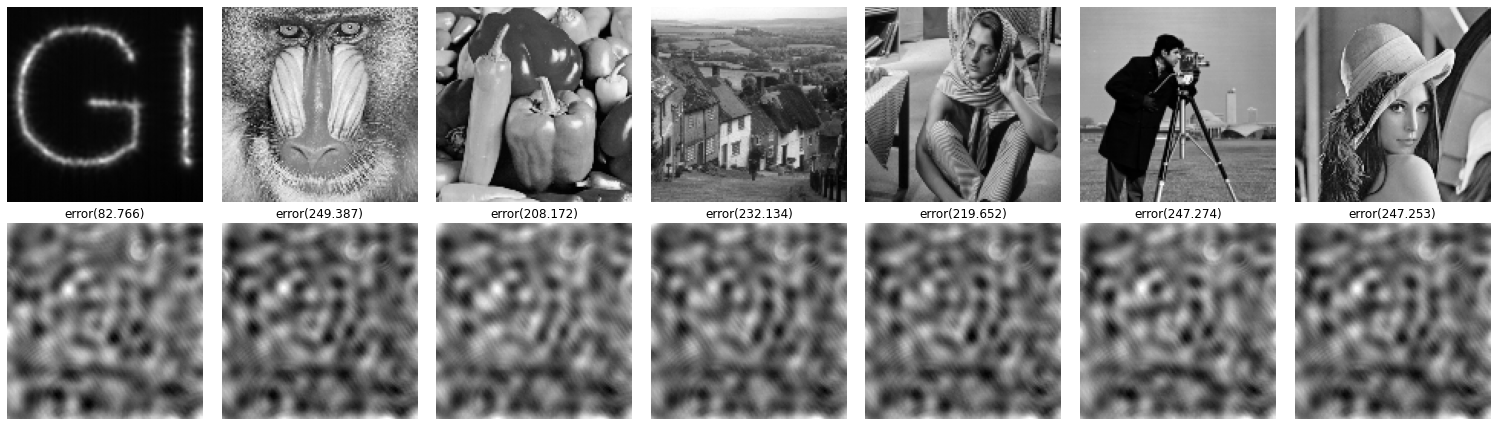

In [18]:
plt.figure(figsize=(7*3,2*3))
for j in range(len(names)):   
    plt.subplot(2,7,j+1)
    plt.imshow(x_uu_list[j].cpu().numpy().reshape((Width,Height)),cmap="gray")
    plt.axis("off")
    
    plt.subplot(2,7,j+1+7)
    recv_img = recv_res[j]
    e = error_res[j]
    plt.imshow(recv_img.cpu().numpy().reshape((Width,Height)),cmap="gray")
    plt.title("error({})".format(round(e,3)))
    plt.axis("off")
plt.tight_layout(pad=1)
# plt.show()
plt.savefig("{}/mismatch_recv_res.jpg".format(root))